In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import pandas as pd
from matplotlib import rc
import matplotlib as mpl
import scipy.optimize as opt
rc('text', usetex=True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["legend.borderpad"] = 0.15
mpl.rcParams["font.size"] = 8

In [3]:
def dominant_eigval(L):
    L_sparse = L.data_as('csr_matrix')
    eval = eigs(L_sparse, k=1, which='LR', return_eigenvectors=False, ncv = 100, tol=1e-8)
    return np.real(eval[0])

In [4]:
# check the CGF for the cascaded system
# system parameters

N=5

dphi = 0.1
omega_c = N/2
beta0 = 0.35
omega0 = beta0 * omega_c
ds = 10**(-4)
ddphi = 10**(-4)

    # Collective spin operators 

S_x = jmat(N/2, 'x')
S_y = jmat(N/2, 'y')
S_z = jmat(N/2, 'z')
S_p = jmat(N/2, '+')
S_m = jmat(N/2, '-')
idenJ = qeye(S_z.shape[0])

    # operators of the sensor system S_1

S_x1 = tensor(S_x, idenJ)
S_x2 = tensor(idenJ, S_x)
S_m1 = tensor(S_m, idenJ)

    # operators of the decoder system S_2

S_m2 = tensor(idenJ, S_m)
S_p1 = tensor(S_p, idenJ)
S_p2 = tensor(idenJ, S_p)

    # identity

idenJ = tensor(idenJ, idenJ)

    # function that builds the vectorized Lindblad Superoperator for the
    # deformed Master Equation

def L(ds, omega, dphi, ddphi):
    Ham = omega*(S_x1+S_x2)-0.5j*(np.exp(-1j*(dphi+ddphi))*S_p2*S_m1 - np.exp(1j*(dphi+ddphi))*S_p1*S_m2)
    HamT = (Ham.dag()).conj()
    Jump = S_m1+np.exp(1j*(dphi+ddphi))*S_m2
    JumpD = Jump.dag()
    JpJm = JumpD*Jump
    JpJmT = (JpJm.dag()).conj()
    L = (-1j*(tensor(idenJ, Ham)-tensor(HamT, idenJ))+np.exp(-ds)*tensor(Jump.conj(), Jump)
        -0.5*(tensor(idenJ, JpJm))-0.5*(tensor(JpJmT, idenJ)))
    return L

    # a function that diagonalizes a Master operator and returns its
    # dominant eigenvalue


def CGF(ds, omega, dphi, ddphi):
    return 2*(np.exp(-ds)-1)*omega**2 *(1-np.cos(dphi+ddphi))

lambdas = np.array([])

for s in np.arange(-1, 1, 0.1):
    LM = L(s, omega0, dphi, 0)
    lambdas = np.append(lambdas, dominant_eigval(LM))

In [5]:
# calculate relative error for cgf in cascaded system for various system sizes N
errors = np.array([[0,0,0]])
for N in [5,6,7]:
    dphi = 0.1
    omega_c = N/2
    for beta in np.arange(0.1,0.5,0.02):
        omega = beta * omega_c
        s = -0.05
        # Collective spin operators 
        S_x = jmat(N/2, 'x')
        S_y = jmat(N/2, 'y')
        S_z = jmat(N/2, 'z')
        S_p = jmat(N/2, '+')
        S_m = jmat(N/2, '-')
        idenJ = qeye(S_z.shape[0])
        # operators of the sensor system S_1
        S_x1 = tensor(S_x, idenJ)
        S_x2 = tensor(idenJ, S_x)
        S_m1 = tensor(S_m, idenJ)
        # operators of the decoder system S_2
        S_m2 = tensor(idenJ, S_m)
        S_p1 = tensor(S_p, idenJ)
        S_p2 = tensor(idenJ, S_p)
        # identity
        idenJ = tensor(idenJ, idenJ)
        LM = L(s, omega, dphi, 0)
        err = abs(dominant_eigval(LM) - CGF(s,omega,dphi,0))/dominant_eigval(LM)
        errors = np.append(errors, [[N,beta,err]],axis=0)

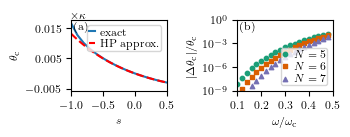

In [7]:
colors=['#1b9e77','#d95f02','#7570b3']
marker = ['o', 's', '^']
df = pd.DataFrame(errors, columns=['N','beta','err'])
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(1*3.54331,0.4*3.54331),
                                     width_ratios=[1,1], layout='tight')
ax1.plot(np.arange(-1, 1, 0.1), lambdas, label='exact')
ax1.plot(np.arange(-1, 1, 0.05), CGF(np.arange(-1, 1, 0.05), omega0, dphi, 0), 'r--', 
         label='HP approx.')
ax1.set_xlim(-1,0.5)
ax1.set_yticks([-0.005,0.005,0.015])
ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r'$s$')
ax1.set_ylabel(r'$\theta_\mathrm{c}$')
ax1.legend(handletextpad=0.5,handlelength=0.5, loc='best', labelspacing=0.2)
ax1.text(0,1.01,r'$\times\kappa$',transform=ax1.transAxes, ha='left', va='bottom')
ax2.scatter(df['beta'].loc[df['N']==5],df['err'].loc[df['N']==5], color=colors[0], marker=marker[0], s=10, label=r'$N=5$')
ax2.scatter(df['beta'].loc[df['N']==6],df['err'].loc[df['N']==6], color=colors[1], marker=marker[1], s=10, label=r'$N=6$')
ax2.scatter(df['beta'].loc[df['N']==7],df['err'].loc[df['N']==7], color=colors[2], marker=marker[2], s=10, label=r'$N=7$')
ax2.set_yscale('log')
ax2.set_xlim(0.1,0.5)
ax2.set_ylim(1e-9,1e-1)
ax2.set_yticks([1e-9,1e-6,1e-3,1e0])
ax2.set_xticks([0.1,0.2,0.3,0.4,0.5])
ax2.set_xlabel(r'$\omega/\omega_\mathrm{c}$')
ax2.set_ylabel(r'$|\Delta \theta_\mathrm{c}|/\theta_\mathrm{c}$')
ax2.legend(handletextpad=0.5,handlelength=0.5, loc='best', labelspacing=0.2)
ax1.text(0.03, 0.98, '(a)', transform=ax1.transAxes, va='top')
ax2.text(0.03, 0.98, '(b)', transform=ax2.transAxes, va='top')
# --- IGNORE ---
fig.savefig('cgf_cascaded_hp_approx.pdf', dpi=1000)